In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
tf.random.set_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

2023-06-20 18:05:46.167584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Preprocessed data: https://ieee-dataport.org/open-access/preprocessed-chb-mit-scalp-eeg-database

In [2]:
df = pd.read_csv("/Users/madhavp/DRL/chbmit_preprocessed_data.csv")
df.head()

,# FP1-F7,C3-P3,C4-P4,CZ-PZ,F3-C3,F4-C4,F7-T7,F8-T8,FP1-F3,FP2-F4,...,P3-O1,P4-O2,P7-O1,P7-T7,P8-O2,T7-FT9,T7-P7,T8-P8-0,T8-P8-1,Outcome
0,0.000020,0.000010,0.000022,0.000037,0.000032,0.000035,0.000016,0.000046,-0.000007,0.000043,...,0.000024,-0.000030,0.000010,-0.000011,-0.000037,0.000008,0.000012,0.000021,0.000021,0.0
1,0.000022,0.000008,0.000021,0.000039,0.000030,0.000032,0.000015,0.000039,-0.000006,0.000042,...,0.000026,-0.000017,0.000012,-0.000008,-0.000029,0.000010,0.000009,0.000023,0.000023,0.0
2,0.000021,0.000012,0.000021,0.000040,0.000025,0.000030,0.000013,0.000036,-0.000006,0.000040,...,0.000027,-0.000018,0.000014,-0.000009,-0.000034,0.000012,0.000009,0.000027,0.000027,0.0
3,0.000019,0.000012,0.000021,0.000039,0.000023,0.000028,0.000013,0.000035,-0.000008,0.000036,...,0.000030,-0.000024,0.000015,-0.000009,-0.000042,0.000009,0.000010,0.000033,0.000033,0.0
4,0.000019,0.000012,0.000021,0.000036,0.000023,0.000024,0.000012,0.000024,-0.000009,0.000032,...,0.000032,-0.000014,0.000017,-0.000008,-0.000031,0.000009,0.000008,0.000035,0.000035,0.0


In [3]:
df.rename(columns = {'Outcome':'y'}, inplace = True)

In [4]:
print(df.columns)

Index(['# FP1-F7', 'C3-P3', 'C4-P4', 'CZ-PZ', 'F3-C3', 'F4-C4', 'F7-T7',
       'F8-T8', 'FP1-F3', 'FP2-F4', 'FP2-F8', 'FT10-T8', 'FT9-FT10', 'FZ-CZ',
       'P3-O1', 'P4-O2', 'P7-O1', 'P7-T7', 'P8-O2', 'T7-FT9', 'T7-P7',
       'T8-P8-0', 'T8-P8-1', 'y'],
      dtype='object')


In [5]:
df.head(n=5)

,# FP1-F7,C3-P3,C4-P4,CZ-PZ,F3-C3,F4-C4,F7-T7,F8-T8,FP1-F3,FP2-F4,...,P3-O1,P4-O2,P7-O1,P7-T7,P8-O2,T7-FT9,T7-P7,T8-P8-0,T8-P8-1,y
0,0.000020,0.000010,0.000022,0.000037,0.000032,0.000035,0.000016,0.000046,-0.000007,0.000043,...,0.000024,-0.000030,0.000010,-0.000011,-0.000037,0.000008,0.000012,0.000021,0.000021,0.0
1,0.000022,0.000008,0.000021,0.000039,0.000030,0.000032,0.000015,0.000039,-0.000006,0.000042,...,0.000026,-0.000017,0.000012,-0.000008,-0.000029,0.000010,0.000009,0.000023,0.000023,0.0
2,0.000021,0.000012,0.000021,0.000040,0.000025,0.000030,0.000013,0.000036,-0.000006,0.000040,...,0.000027,-0.000018,0.000014,-0.000009,-0.000034,0.000012,0.000009,0.000027,0.000027,0.0
3,0.000019,0.000012,0.000021,0.000039,0.000023,0.000028,0.000013,0.000035,-0.000008,0.000036,...,0.000030,-0.000024,0.000015,-0.000009,-0.000042,0.000009,0.000010,0.000033,0.000033,0.0
4,0.000019,0.000012,0.000021,0.000036,0.000023,0.000024,0.000012,0.000024,-0.000009,0.000032,...,0.000032,-0.000014,0.000017,-0.000008,-0.000031,0.000009,0.000008,0.000035,0.000035,0.0


In [6]:
df.shape

(2097150, 24)

In [7]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [8]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize the data


It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [9]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

### Model

In [10]:
nb_epoch = 20
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables,
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 23)                759       
                                                                 
Total params: 2,871
Trainable params: 2,871
Non-trainable par

In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/20
5243/5243 [==============================] - 11s 2ms/step - loss: 0.1551 - accuracy: 0.5910 - val_loss: 0.0847 - val_accuracy: 0.6951
Epoch 2/20
5243/5243 [==============================] - 10s 2ms/step - loss: 0.0777 - accuracy: 0.6901 - val_loss: 0.0746 - val_accuracy: 0.6702
Epoch 3/20
5243/5243 [==============================] - 10s 2ms/step - loss: 0.0646 - accuracy: 0.7168 - val_loss: 0.0563 - val_accuracy: 0.7637
Epoch 4/20
5243/5243 [==============================] - 16s 3ms/step - loss: 0.0551 - accuracy: 0.7423 - val_loss: 0.0533 - val_accuracy: 0.7768
Epoch 5/20
5243/5243 [==============================] - 10s 2ms/step - loss: 0.0537 - accuracy: 0.7459 - val_loss: 0.0527 - val_accuracy: 0.7713
Epoch 6/20
5243/5243 [==============================] - 12s 2ms/step - loss: 0.0529 - accuracy: 0.7457 - val_loss: 0.0526 - val_accuracy: 0.7731
Epoch 7/20
5243/5243 [==============================] - 11s 2ms/step - loss: 0.0525 - accuracy: 0.7472 - val_loss: 0.0515 - val_ac

In [18]:
autoencoder = load_model('autoencoder_classifier.h5')

### Results

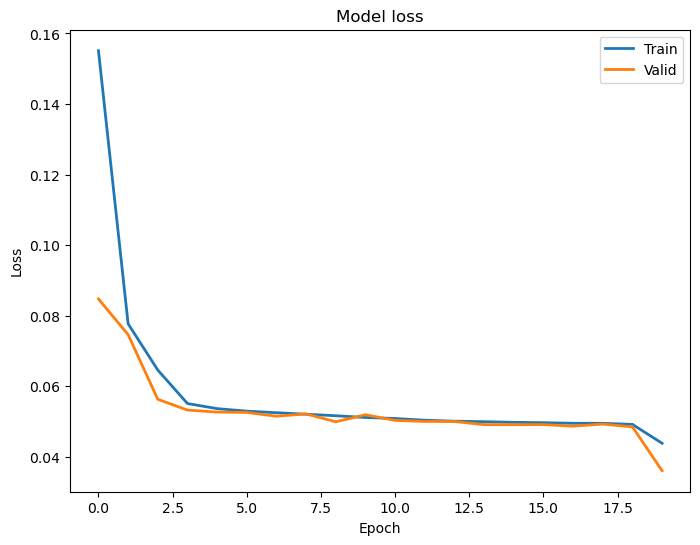

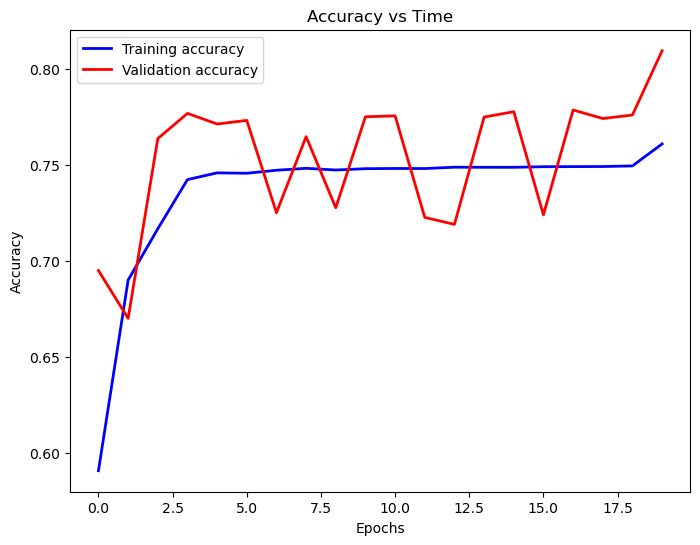

In [12]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


# Plot accuracy versus time
plt.plot(history['accuracy'], 'b', linewidth=2, label='Training accuracy')
plt.plot(history['val_accuracy'], 'r',linewidth=2, label='Validation accuracy')
plt.title('Accuracy vs Time')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

10486/10486 [==============================] - 9s 869us/step


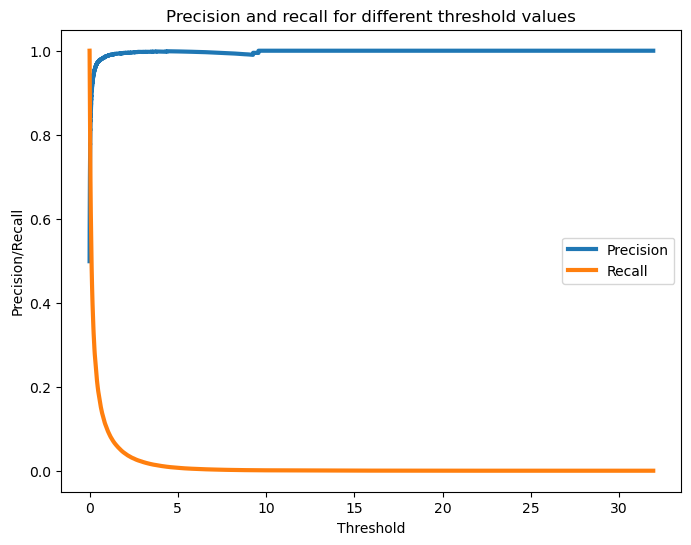

In [13]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=3)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=3)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [14]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

13108/13108 [==============================] - 12s 949us/step


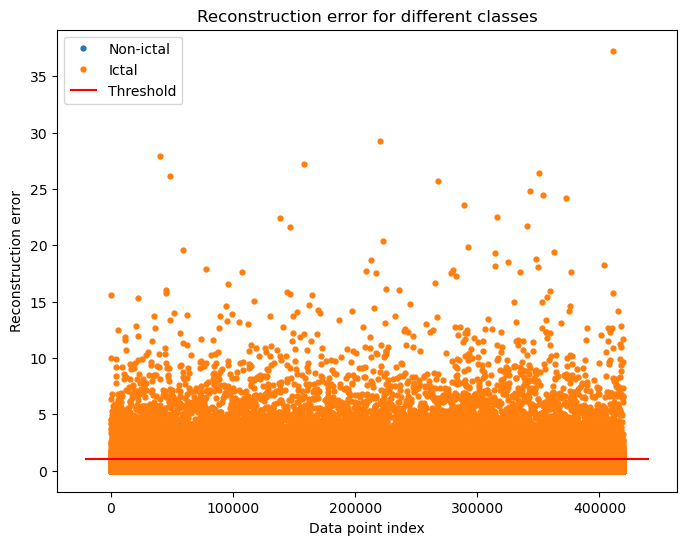

In [15]:
threshold_fixed = 1
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Ictal" if name == 1 else "Non-ictal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [16]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


In [17]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

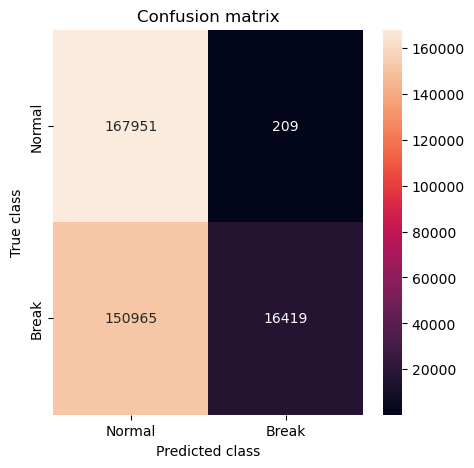

In [18]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

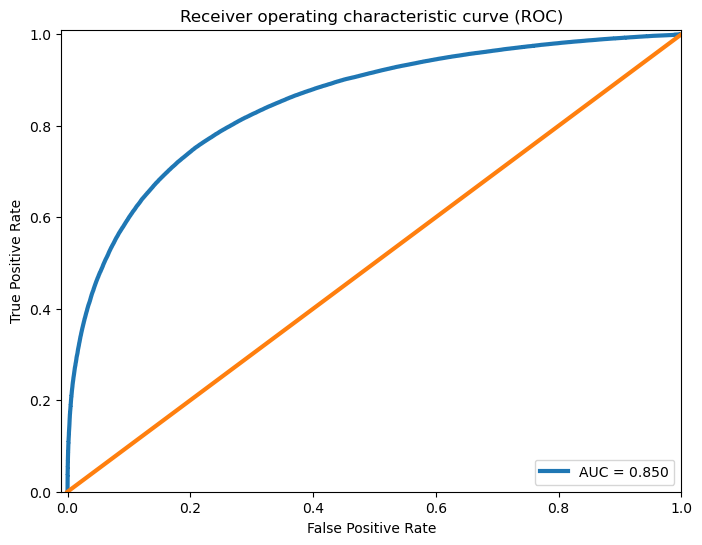

In [20]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=3)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## CNN with Autoencoder

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Reshape
import numpy as np

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(4, 4, 32))) 
cnn_model.add(MaxPooling2D((2, 2)))
# cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
# cnn_model.add(MaxPooling2D((2, 2)))
# cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output of the CNN model
cnn_model.add(Flatten())

# Create the input layer for the encoder output
encoder_output = Input(shape=(encoding_dim,))
preprocessing_output = Reshape((4, 4, 2))(encoder_output)

# Join with the encoder layer of the autoencoder
preprocessing_output = Dense(32, activation='relu')(preprocessing_output)  # Example additional layer

# Combine the CNN model with the encoder output
preprocessing_output = cnn_model(preprocessing_output)

# Create the combined model
combined_model = Model(inputs=encoder_output, outputs=preprocessing_output)
combined_model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32)]              0         
                                                                 
 reshape_9 (Reshape)         (None, 4, 4, 2)           0         
                                                                 
 dense_19 (Dense)            (None, 4, 4, 32)          96        
                                                                 
 sequential_21 (Sequential)  (None, 32)                9248      
                                                                 
Total params: 9,344
Trainable params: 9,344
Non-trainable params: 0
_________________________________________________________________


In [51]:
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [52]:
combined_model.fit(df_train_0_x_rescaled, df_train_0_x_rescaled, epochs=10, batch_size=32)


Epoch 1/10


ValueError: in user code:

    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/madhavp/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 32), found shape=(None, 23)


## Previous Results

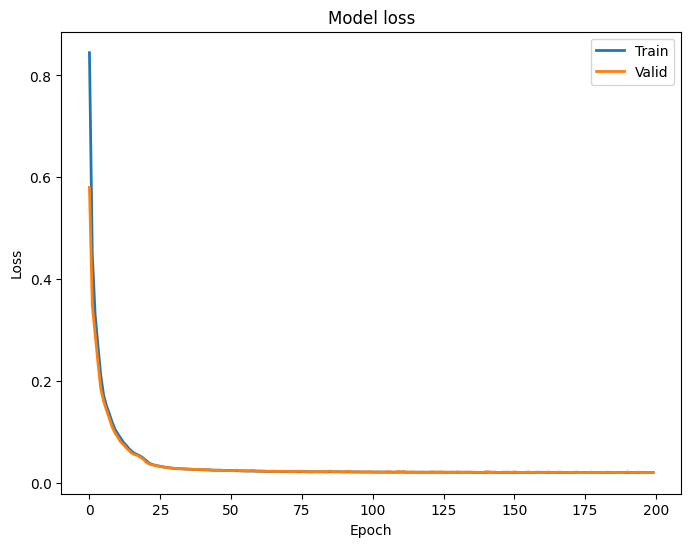

In [37]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

259/259 [==============================] - 0s 1ms/step


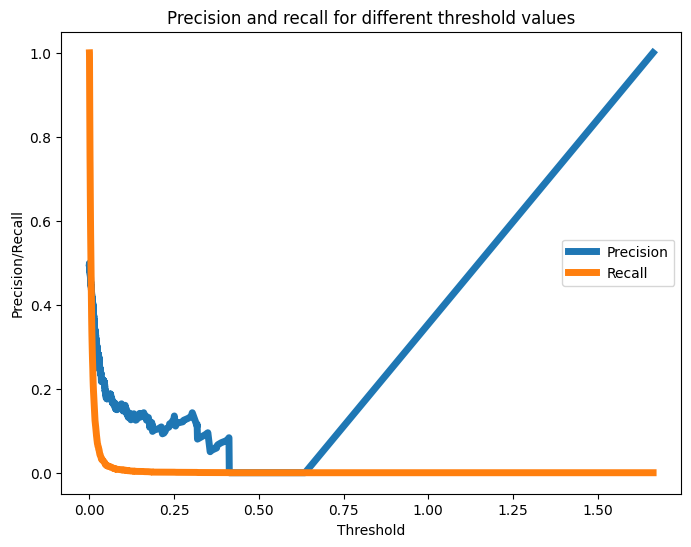

In [38]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

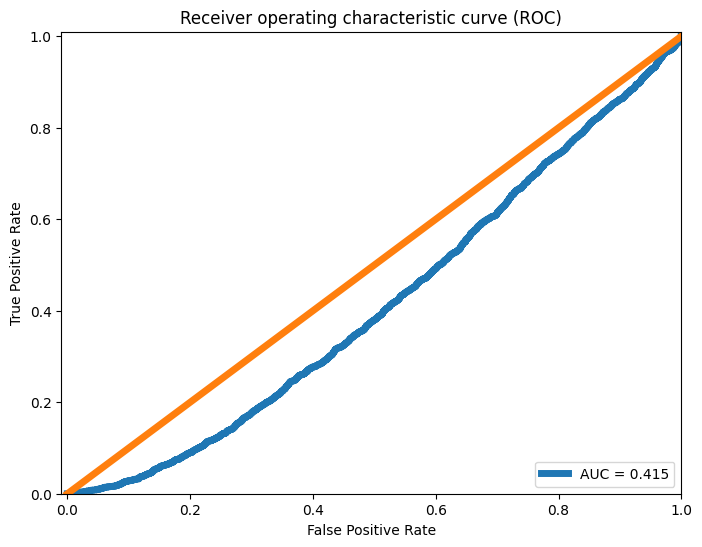

In [44]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [59]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the data from CSV file
data = pd.read_csv('/Users/madhavp/DRL/chbmit_preprocessed_data.csv')
# data = pd.read_csv('/Users/madhavp/DRL/SeizureDetection/CHB_Res_rand.csv')


# Separate features (X) and outcomes (y)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()


# Training the model
print("Training the Random Forest classifier...")
start_time = time.time()
rf_classifier.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training completed. Training time: {:.2f} seconds".format(training_time))

# Make predictions on the test set
print("Making predictions on the test set...")
start_time = time.time()
predictions = rf_classifier.predict(X_test)
end_time = time.time()
testing_time = end_time - start_time
print("Predictions completed. Testing time: {:.2f} seconds".format(testing_time))

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Training the Random Forest classifier...


KeyboardInterrupt: 